In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np, os

In [4]:
DATASET_DIR = "/content/drive/MyDrive/Datasets/Skin Cancer with Categories/Skin cancer ISIC/Train"
IMG_SIZE = (300, 300)
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 9

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [6]:
all_labels = []
for _, labels in train_ds.unbatch():
    all_labels.append(int(labels.numpy()))

classes = np.unique(all_labels)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=all_labels
)

class_weights = {i: float(w) for i, w in enumerate(class_weights_array)}
print(class_weights)
max_weight = max(class_weights.values())
normalized_class_weights = {c: w / max_weight for c, w in class_weights.items()}
print(normalized_class_weights)

{0: 2.1642512077294684, 1: 0.6443725278676735, 2: 2.585858585858586, 3: 0.5656565656565656, 4: 0.7188126754913758, 5: 0.5381381381381382, 6: 3.4329501915708813, 7: 1.402190923317684, 8: 1.731400966183575}
{0: 0.6304347826086956, 1: 0.18770226537216828, 2: 0.7532467532467533, 3: 0.16477272727272727, 4: 0.20938628158844763, 5: 0.15675675675675677, 6: 1.0, 7: 0.4084507042253521, 8: 0.5043478260869565}


In [7]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

train_ds = train_ds.map(normalize_img)
val_ds = val_ds.map(normalize_img)

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomFlip("horizontal_and_vertical")
])

In [10]:
base_model = EfficientNetB1(
    input_shape=(300,300,3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = True
for layer in base_model.layers[:120]:
    layer.trainable = False

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu"),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=50,
    restore_best_weights=True,
    monitor='val_loss'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=50,
    min_lr=1e-6
)

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=normalized_class_weights,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.1193 - loss: 0.9260 - val_accuracy: 0.1499 - val_loss: 2.2233 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 494ms/step - accuracy: 0.1467 - loss: 0.8601 - val_accuracy: 0.0425 - val_loss: 2.3434 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 519ms/step - accuracy: 0.1942 - loss: 0.7788 - val_accuracy: 0.0425 - val_loss: 2.5243 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 502ms/step - accuracy: 0.1900 - loss: 0.6986 - val_accuracy: 0.0425 - val_loss: 2.4620 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 520ms/step - accuracy: 0.2079 - loss: 0.6840 - val_accuracy: 0.0492 - val_loss: 2.3221 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 511ms/step - accuracy: 0.2363 - loss: 0.6451 - val_accuracy: 0.0425 - val_loss: 2.2279 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 521ms/step - accuracy: 0.2777 - loss: 0.57

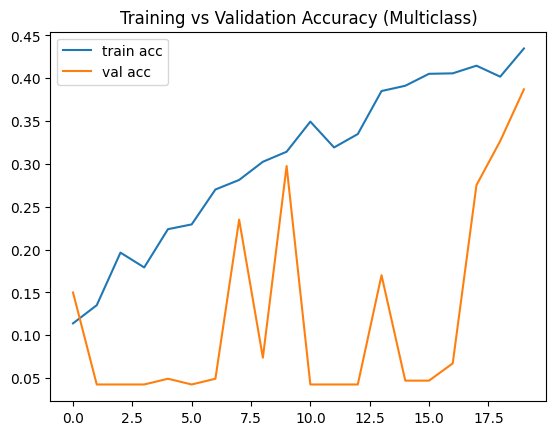

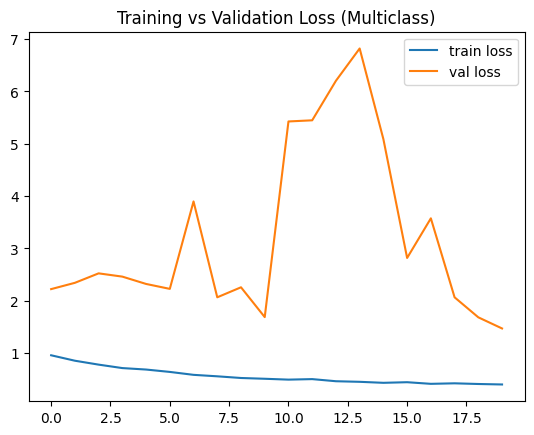

In [14]:
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.legend(); plt.title("Training vs Validation Accuracy (Multiclass)"); plt.show()

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend(); plt.title("Training vs Validation Loss (Multiclass)"); plt.show()

In [15]:
save_path_ft =  "/content/drive/MyDrive/skin-cancer/saved_models/modelo_lesiones.keras"
os.makedirs(os.path.dirname(save_path_ft), exist_ok=True)
model.save(save_path_ft)
print(f" Modelo afinado guardado correctamente en: {save_path_ft}")

 Modelo afinado guardado correctamente en: /content/drive/MyDrive/skin-cancer/saved_models/modelo_lesiones.keras
